In [1]:
import tensorflow as tf
from tensorflow.python import keras
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, Lambda, LSTM, Bidirectional, SimpleRNN, Dense
from keras.losses import Huber
from keras.optimizers import SGD
from keras.metrics import mean_absolute_error

import netCDF4 as nc
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import csv

In [2]:
# Open the NetCDF file
dataset = nc.Dataset('mascons.nc')

# Loop through all variables
for variable_name, variable in dataset.variables.items():
    print("Variable:", variable_name)
    print("Dimensions:", variable.dimensions)
    print("Shape:", variable.shape)
    print("-------------------------------------")

# Close the NetCDF file
dataset.close()


Variable: lon
Dimensions: ('lon',)
Shape: (720,)
-------------------------------------
Variable: lat
Dimensions: ('lat',)
Shape: (360,)
-------------------------------------
Variable: time
Dimensions: ('time',)
Shape: (215,)
-------------------------------------
Variable: land_mask
Dimensions: ('lat', 'lon')
Shape: (360, 720)
-------------------------------------
Variable: lwe_thickness
Dimensions: ('time', 'lat', 'lon')
Shape: (215, 360, 720)
-------------------------------------
Variable: lon_bounds
Dimensions: ('lon', 'bounds')
Shape: (720, 2)
-------------------------------------
Variable: lat_bounds
Dimensions: ('lat', 'bounds')
Shape: (360, 2)
-------------------------------------
Variable: time_bounds
Dimensions: ('time', 'bounds')
Shape: (215, 2)
-------------------------------------


In [3]:
# Open the netCDF file
data = nc.Dataset('mascons.nc', 'r')

# Get the variable 'lwe_thickness' from the dataset
lwe_thickness_variable = data.variables['lwe_thickness']

# Read the data from the variable into a multidimensional NumPy array
lwe_thickness_data = lwe_thickness_variable[:]

# Get the time variable from the dataset
time_variable = data.variables['time']

# Read the time values into a NumPy array
time_values = time_variable[:]

# Get the latitude variable from the dataset
lat_variable = data.variables['lat']

# Read the lat values into a NumPy array
lat_values = lat_variable[:]

# Close the netCDF file
data.close()

# The 'lwe_thickness_data' is now a multidimensional NumPy array.
# You can access its shape using the 'shape' attribute.
print("Shape of lwe_thickness_data:", lwe_thickness_data.shape)

Shape of lwe_thickness_data: (215, 360, 720)


In [4]:
print(f"Time: {lwe_thickness_data[:,0,0]}")
print(f"Latitude: {lwe_thickness_data[0,:,0]}")

Time: [-10.31942682  -9.71116114  -8.32613783  -6.03589839  -5.42778718
  -7.67271859  -4.29428072  -4.30421395  -7.9261281   -6.48089053
  -5.43699009  -5.21745685  -6.10456737  -6.51867092  -6.34115149
  -3.21879243  -4.17137263  -6.10114483  -7.3076954   -6.72809126
  -4.72964143  -6.00077915  -4.23850869  -3.60638178  -7.09948151
  -4.73579875  -4.23982194  -1.1007809   -4.66010726  -5.36300422
  -6.35391558  -6.95632061  -6.05999702  -4.80983498  -4.63057215
  -4.45938117  -3.31885374  -3.70795336  -3.46046367  -2.37544226
  -0.95925838  -2.42162808  -3.34736234  -2.35325091  -2.47283386
  -2.65522955  -0.10327658  -1.02168525  -1.72900305  -0.32590693
   0.27713484   1.44335563   1.62005215   0.54625963  -2.77360621
   0.26738927  -1.0070458   -1.24730938   0.52372942   1.93748407
   1.70023051   2.14558319   4.56049715   3.56140705   1.46166586
   1.74551226   1.46391435   2.54666561   1.09641816   3.46342952
   3.88570321   3.13217393   1.30564144   1.3326021    6.08834039
   5

In [5]:
def plot_series(x, y, name, color=None):
    if not color:
        plt.plot(x, y)
    else:
        plt.plot(x, y, color)
    plt.title(name)
    plt.xlabel("Time Steps")
    plt.ylabel("lwe Thickness")

In [6]:
time = []
thickness = []

for time_index in range(lwe_thickness_data.shape[0]):
  # Access the value at the current time
  current_value = lwe_thickness_data[time_index, 0, 0]
  # Access the corresponding time value at lon=0, lat=0
  current_time = time_values[time_index]
  # 'current_time' will be the time value at the current time index.
  time.append(time_index)
  thickness.append(current_value)

steps = np.array(time)
lwe =  np.array(thickness)

In [7]:
lwe

array([-10.31942682,  -9.71116114,  -8.32613783,  -6.03589839,
        -5.42778718,  -7.67271859,  -4.29428072,  -4.30421395,
        -7.9261281 ,  -6.48089053,  -5.43699009,  -5.21745685,
        -6.10456737,  -6.51867092,  -6.34115149,  -3.21879243,
        -4.17137263,  -6.10114483,  -7.3076954 ,  -6.72809126,
        -4.72964143,  -6.00077915,  -4.23850869,  -3.60638178,
        -7.09948151,  -4.73579875,  -4.23982194,  -1.1007809 ,
        -4.66010726,  -5.36300422,  -6.35391558,  -6.95632061,
        -6.05999702,  -4.80983498,  -4.63057215,  -4.45938117,
        -3.31885374,  -3.70795336,  -3.46046367,  -2.37544226,
        -0.95925838,  -2.42162808,  -3.34736234,  -2.35325091,
        -2.47283386,  -2.65522955,  -0.10327658,  -1.02168525,
        -1.72900305,  -0.32590693,   0.27713484,   1.44335563,
         1.62005215,   0.54625963,  -2.77360621,   0.26738927,
        -1.0070458 ,  -1.24730938,   0.52372942,   1.93748407,
         1.70023051,   2.14558319,   4.56049715,   3.56

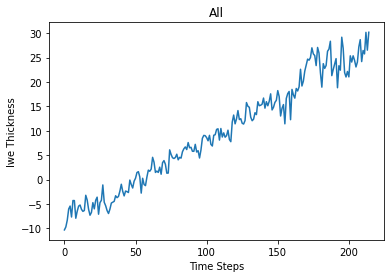

In [8]:
plot_series(steps, lwe, "All")

split_time = 180

train_steps = steps[: split_time]
train_lwe = lwe[: split_time]

val_steps = steps[split_time:]
val_lwe = lwe[split_time:]

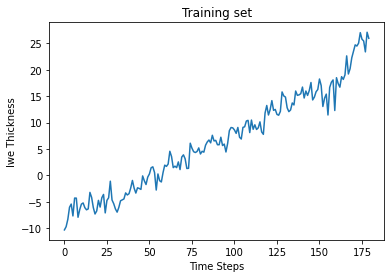

In [9]:
plot_series(train_steps, train_lwe, "Training set")

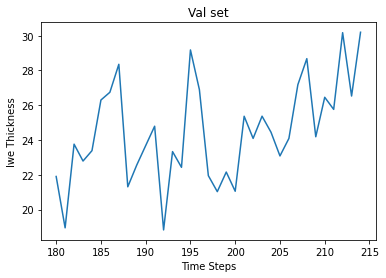

In [10]:
plot_series(val_steps, val_lwe, "Val set")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=711.438, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=695.707, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=675.268, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=711.831, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=670.621, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=671.877, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=671.762, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=669.774, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=671.762, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=670.226, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=685.231, Time=0.03 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.038 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  180
Model: 

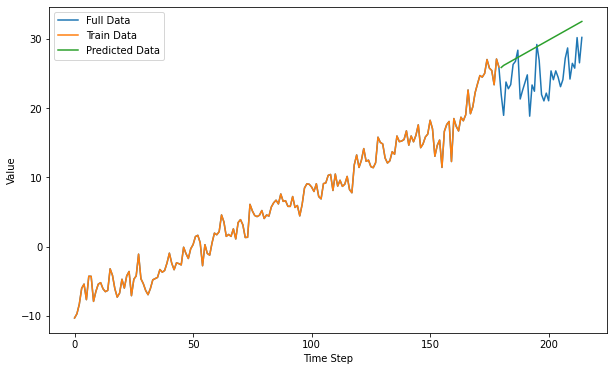

In [14]:
import pmdarima as pm

# Sample time steps and values (replace this with your actual data)
time_steps = np.arange(1, 21)

# Perform auto ARIMA model selection
model = pm.auto_arima(train_lwe, start_p=0, max_p=10, start_q=0, max_q=10, d=None,
                      seasonal=False, stepwise=True, suppress_warnings=True,
                      error_action="ignore", trace=True)

# Print the model summary to see the selected parameters (p, d, q)
print(model.summary())

# Get the forecasted values
forecast_steps = len(val_steps)
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)

# Optionally, plot the predicted values
plt.figure(figsize=(10, 6))
plt.plot(steps, lwe, label='Full Data')
plt.plot(train_steps, train_lwe, label='Train Data')
plt.plot(np.arange(train_steps[-1] + 1, train_steps[-1] + forecast_steps + 1), forecast, label='Predicted Data')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()

In [ ]:
# Define the order of the ARIMA model (p, d, q)
p, d, q = 0, 1, 2

# Create the ARIMA model
model = ARIMA(train_lwe, order=(p, d, q))

# Fit the model to the data
results = model.fit()

# Define the number of steps to forecast into the future
forecast_steps = len(val_steps)

# Generate predictions for the future
forecast = results.forecast(steps=forecast_steps)

# Create new time steps for the future predictions
future_time_steps = val_steps

# Combine time steps and forecasted values
future_predictions = np.column_stack((future_time_steps, forecast))

# Optionally, plot the predicted values
plt.plot(steps, lwe, label='Actual Data')
plt.plot(future_predictions[:, 0], future_predictions[:, 1], label='Predicted Data')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('lwe')
plt.show()

# Display the future predictions
print(future_predictions)

In [ ]:
# Assuming you have the actual values for the data points
# Replace this with your actual data (actual_values should be a NumPy array or a list)
actual_values = np.array([12.5, 13.8, 10.6, 11.9, 10.3, 12.6, 14.3, 9.7, 11.4, 10.9])

# Assuming you have the forecasted values from ARIMA
# Replace this with your actual forecasted values
forecasted_values = np.array([12.1, 14.0, 10.2, 11.5, 10.9, 12.7, 14.1, 10.1, 11.8, 10.6])

# Calculate the Mean Absolute Error (MAE)
mae = np.mean(np.abs(actual_values - forecasted_values))
print("Mean Absolute Error (MAE):", mae)